In [1]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab import evaluate_agent, multiConstAction, simulator
import matplotlib.pyplot as plt 
from ipywidgets import interact, widgets
from huggingface_hub import hf_hub_download
from stable_baselines3 import PPO, TD3
from stable_baselines3.common.env_util import make_vec_env
from sb3_contrib import TQC, RecurrentPPO

2025-05-07 00:10:23,332	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.5 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    "curriculum": True
}

In [3]:
env = greenCrabMonthEnvNormalized(config)
vec_env = make_vec_env(greenCrabMonthEnvNormalized, n_envs=12)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [4]:
model_config = {
    'policy':"MultiInputLstmPolicy",
    'env':vec_env,
    'verbose':0,
    'normalize_advantage': True,
    'batch_size': 256,
    'n_steps': 1024,
    'gamma': 0.9999,
    'learning_rate': 7.77e-05,
    'ent_coef': 0.00429,
    'clip_range': 0.1,
    'n_epochs': 10,
    'gae_lambda': 0.9,
    'max_grad_norm': 5,
    'vf_coef': 0.19,
    'use_sde': True,
    'sde_sample_freq': 8,
    'tensorboard_log':"/home/rstudio/logs",
    'policy_kwargs': dict(log_std_init=0.0, ortho_init=False,
                       lstm_hidden_size=32,
                       n_lstm_layers = 1,
                       enable_critic_lstm=True,
                       net_arch=[64, 32, 16])
}

In [5]:
model = RecurrentPPO(**model_config)
model.learn(
	total_timesteps=10_000, 
	progress_bar=True,
)
model.save("ppo_month_observation")

Output()

In [50]:
ppoAgent = PPO.load("ppo_month_observation", device="cpu")

In [51]:
evalEnv = greenCrabMonthEnvNormalized(config)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [52]:
N_EPS = 30

ppo_rew = evaluate_agent(agent=ppoAgent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)

import ray
ray.shutdown()

2025-04-25 18:19:54,018	INFO worker.py:1852 -- Started a local Ray instance.


In [53]:
ppo_rew

-19.94463464966505

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.0,-1.0,-0.147197,-0.129762,-0.431756,0.000000,0
1,1,-1.0,-1.0,-0.152711,-0.088663,-0.519227,-0.182632,0
2,2,-1.0,-1.0,-0.222085,-0.050717,-0.461524,-0.349193,0
3,3,-1.0,-1.0,-0.101512,0.023637,-0.451725,-0.526037,0
4,4,-1.0,-1.0,-0.096511,-0.153473,-0.499020,-0.712638,0
5,5,-1.0,-1.0,-0.055558,-0.196796,-0.309137,-0.882896,0
6,6,-1.0,-1.0,-0.062253,-0.086530,-0.295596,-1.091036,0
7,7,-1.0,-1.0,-0.196259,0.040139,-0.205934,-1.306027,0
8,8,-1.0,-1.0,0.009798,-0.188020,-0.330185,-1.538656,0
9,9,-1.0,-1.0,-0.172461,-0.056148,-0.248807,-1.745552,0


<Axes: xlabel='t'>

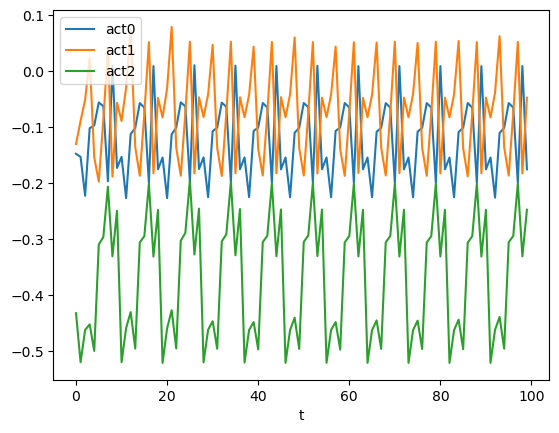

In [54]:
ppoData = simulator(env = evalEnv, agent = ppoAgent).simulate_full_named_dict_obs_acts()
ppoDataDF = pd.DataFrame(ppoData)
display(ppoDataDF.head(10))
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])

<Axes: xlabel='t'>

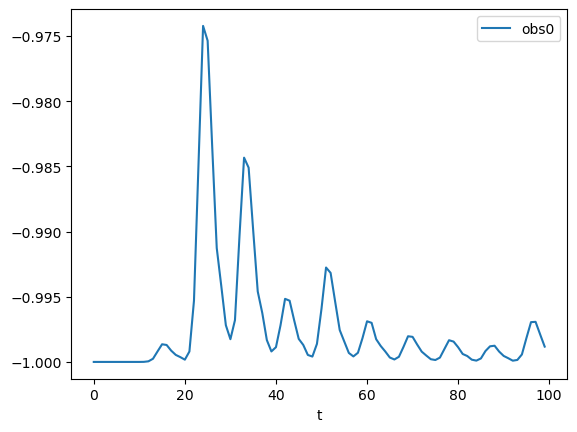

In [55]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['obs0'])

In [24]:
td3Agent = TD3.load("TD3_gcmenorm", device="cpu")

In [25]:
evalEnv = greenCrabMonthEnvNormalized(config)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [28]:
N_EPS = 30

td3_rew = evaluate_agent(agent=td3Agent, env=evalEnv, ray_remote=True).evaluate(n_eval_episodes=N_EPS)

import ray
ray.shutdown()

2025-03-31 18:24:09,945	INFO worker.py:1841 -- Started a local Ray instance.


In [31]:
td3_rew

-1.3325729752744606

,t,obs0,obs1,act0,act1,act2,rew,rep
0,0,-1.0,-1.0,-1.0,-1.000000,-1.0,0.000000,0
1,1,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.000061,0
2,2,-1.0,-1.0,-1.0,-0.165088,-1.0,-0.000123,0
3,3,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.033580,0
4,4,-1.0,-1.0,-1.0,-0.986459,-1.0,-0.033642,0


<Axes: xlabel='t'>

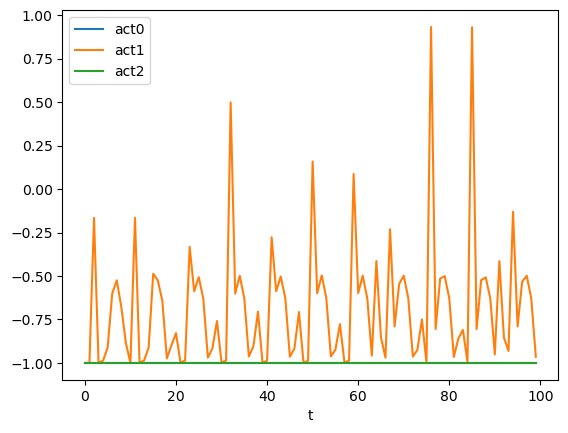

In [30]:
td3Data = simulator(env = evalEnv, agent = td3Agent).simulate_full_named_dict_obs_acts()
td3DataDF = pd.DataFrame(td3Data)
display(td3DataDF.head())
td3DataDF[td3DataDF.rep == 0].plot(x='t', y =['act0', 'act1', 'act2'])

In [ ]:
ppoDataDF[ppoDataDF.rep == 0].plot(x='t', y =['obs0'])